In [1]:
#imports 
import numpy as np
import math
from collections import Counter
#from statsmodels.tsa.stattools import acf
import random
from itertools import combinations, product
import itertools
from multiprocessing import Pool
from tqdm.notebook import tqdm
import random
import networkx as nx

#scipy 
import scipy 
from scipy import stats
from scipy import sparse
from scipy.sparse import linalg

#import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append('../')
sys.path.append('../../pscapes')

from pscapes.landscape_models import make_NK

#scikit
from sklearn.neighbors import kneighbors_graph

#import ruggedness as rg
#from matplotlib.patches import Rectangle, Circle, Polygon,

/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
AMINOS = 'ACD'
N=5
K_vals = list(range(N))

In [7]:


def all_genotypes(N, AAs):
    """Fills the sequence space with all possible genotypes."""
    return [''.join(i) for i in np.array(list(itertools.product(AAs, repeat=N)))]

#defining functions for graph 

def hamming_circle(s, n, alphabet):
    """Generate strings over alphabet whose Hamming distance from s is
    exactly n.
    
    """
    for positions in combinations(range(len(s)), n):
        for replacements in product(range(len(alphabet) - 1), repeat=n):
            cousin = list(s)
            for p, r in zip(positions, replacements):
                if cousin[p] == alphabet[r]:
                    cousin[p] = alphabet[-1]
                else:
                    cousin[p] = alphabet[r]
            yield ''.join(cousin)

def graph_matrices(sequence_space, alphabet, incomplete=False): 
    """Returns adjacency, Laplacian and sequence space for a Hamming graph for a length N protein 
       over a specified alphabet."""
    
    seq_space  = [''.join(list(i)) for i in sequence_space]
    seq_len    = len(seq_space[0])
    alph_len   = len(alphabet)
    
    
    lone = 0
    
    members    = set(seq_space)
    nodes      = {x:y for x,y in zip(seq_space, range(len(seq_space)))}
    adjacency  = sparse.lil_matrix((len(seq_space), len(seq_space)), dtype='int8') 
    
    for ind in range(len(sequence_space)):        
        seq = sequence_space[ind]     
        
        g=0
        
        for neighbor in hamming_circle(seq, 1,alphabet):
            if incomplete:
                try:
                    adjacency[ind,nodes[neighbor]]=1
                    g+=1
                except: 
                    pass
            else:                 
            
                adjacency[ind,nodes[neighbor]]=1
        if g==0:
            lone+=1
            
            
    degree    = (seq_len*(alph_len-1))*sparse.eye(len(seq_space))
    
    laplacian = degree - adjacency
    
    return laplacian.tocsc(), adjacency.tocsc(), degree.tocsc()

def cyclic_group_im(n): 
    """Returns cyclic group of order n in the complex numbers"""
    return np.array([np.exp((2*np.pi*1j*(i))/n) for i in range(n)])

    
def draw_radial_hierarchical(G,radius,alphabet, root=None): 
    """Draw a graph with hierarchical radial layout. Ensure that nodes have associated sequences in the attributes"""
    if root==None: 
        root = random.sample(graph.nodes(), k=1)[0]
    
    seed_seq       = G.nodes[root]['seq']
    max_dist       = len(seed_seq)
    neighborhoods  = [list(hamming_circle(seed_seq, n+1, alphabet=alphabet)) for n in range(max_dist)]
    positions_im   = [cyclic_group_im(len(n)) for n in neighborhoods]
    positions_1    = []
    r=radius
    for i in positions_im:
        positions_1.append(i*r)
        r+=radius
    positions_2    = [ list(zip(np.real(t), np.imag(t) )) for t in positions_1]
    
    #assign positions 
    positions_dict = [{x:y for x,y in zip(neighborhoods[i], positions_2[i])} for i in range(len(neighborhoods))]
    merged = {}
    for d in positions_dict:
        merged.update(d)
    for ind, i in enumerate(G.nodes()):
        try:
            G.nodes[i]['pos'] = merged[G.nodes[i]['seq']]
        except:
            pass
    G.nodes[root]['pos'] = (0,0)
    
    return G, nx.get_node_attributes(G,'pos'), merged
    
    
    
    

In [9]:
replicate_NKs = [[make_NK(N, k, AMINOS, np.random.uniform) for k in K_vals] for r in range(25)]

In [18]:
replicate_NK_sequences = [[np.array(list(replicate_NKs[r][k].keys())) for k in K_vals] for r in range(25)]

In [16]:
replicate_NK_fitnesses = [[np.array(list(replicate_NKs[r][k].values())) for k in K_vals] for r in range(25)]

In [31]:
r1_NK_sequences = replicate_NK_sequences[0]
r1_NK_fitnesses = replicate_NK_fitnesses[0]

In [10]:
sequence_space = all_genotypes(N, AMINOS)

In [17]:
# generate a graph for the sequence space; produce adjacency and find eigenvectors

L, A, D = graph_matrices(sequence_space, AMINOS)
evals_A, evecs_A = np.linalg.eigh(A.toarray())

In [21]:
# we will quickly check that the order of the sequence space is the same
np.all(replicate_NK_sequences[0][0].flatten() == np.array(sequence_space))

np.True_

In [22]:
landscapes_FT = [[np.dot(evecs_A.T, i) for i in j] for j in replicate_NK_fitnesses]

In [32]:
r1_landscapes_FT = landscapes_FT[0]

In [23]:
def cyclic_group_im(n): 
    """Returns cyclic group of order n in the complex numbers"""
    return np.array([np.exp((2*np.pi*1j*(i))/n) for i in range(n)])


def draw_radial_hierarchical(G,radius,alphabet, root=None): 
    """Draw a graph with hierarchical radial layout. Ensure that nodes have associated sequences in the attributes"""
    if root==None: 
        root = random.sample(graph.nodes(), k=1)[0]
    
    seed_seq       = G.nodes[root]['seq']
    max_dist       = len(seed_seq)
    neighborhoods  = [list(hamming_circle(seed_seq, n+1, alphabet=alphabet)) for n in range(max_dist)]
    positions_im   = [cyclic_group_im(len(n)) for n in neighborhoods]
    positions_1    = []
    r=radius
    for i in positions_im:
        positions_1.append(i*r)
        r+=radius
    positions_2    = [ list(zip(np.real(t), np.imag(t) )) for t in positions_1]
    
    #assign positions 
    positions_dict = [{x:y for x,y in zip(neighborhoods[i], positions_2[i])} for i in range(len(neighborhoods))]
    merged = {}
    for d in positions_dict:
        merged.update(d)
    for ind, i in enumerate(G.nodes()):
        try:
            G.nodes[i]['pos'] = merged[G.nodes[i]['seq']]
        except:
            pass
    G.nodes[root]['pos'] = (0,0)
    
    return G, nx.get_node_attributes(G,'pos'), merged
    
    
    
    
    
        
    
        

### Graph plotting

In [27]:
graph = nx.from_numpy_array(A.toarray())

In [28]:
for ind,i in enumerate(graph.nodes()):
    graph.nodes[i]['seq']=sequence_space[ind]

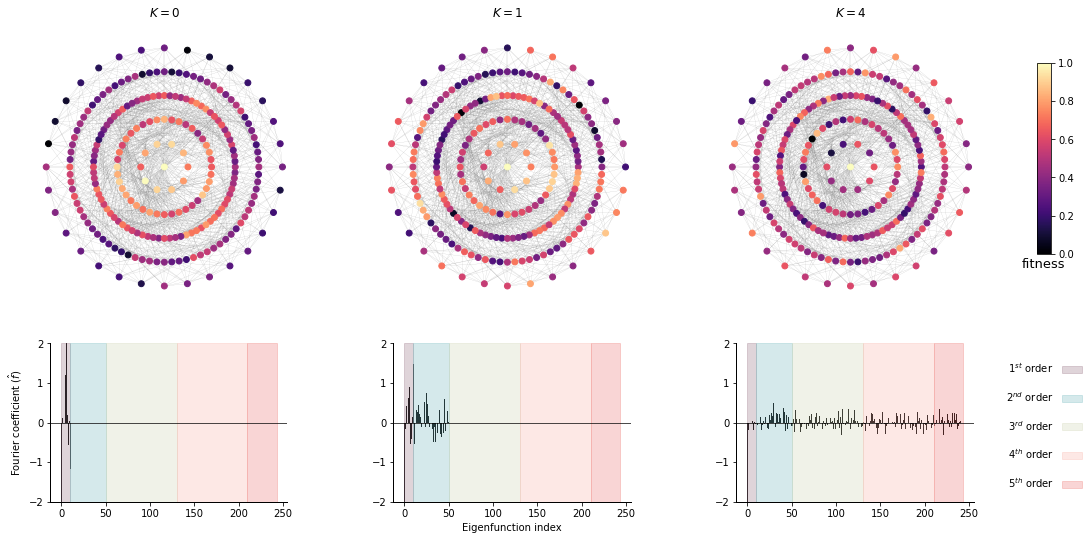

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5.3))
t = draw_radial_hierarchical(graph, 2, AMINOS, root=np.argmax(r1_NK_fitnesses[0].flatten()))
nx.draw(t[0], t[1], node_size=35, edge_color='gray', width=0.1,cmap=plt.get_cmap('magma'),node_color=r1_NK_fitnesses[0].flatten(), 
        ax=ax[0],)# edgecolors='k')
t = draw_radial_hierarchical(graph, 2, AMINOS, root=np.argmax(r1_NK_fitnesses[-1].flatten()))
nx.draw(t[0], t[1], node_size=35, edge_color='gray', width=0.1,cmap=plt.get_cmap('magma'),node_color=r1_NK_fitnesses[-1].flatten(), 
        ax=ax[2],)# edgecolors='k')
t = draw_radial_hierarchical(graph, 2, AMINOS, root=np.argmax(r1_NK_fitnesses[1].flatten()))
nx.draw(t[0], t[1], node_size=35, edge_color='gray', width=0.1,cmap=plt.get_cmap('magma'),node_color=r1_NK_fitnesses[1].flatten(), 
        ax=ax[1],)# edgecolors='k')

ax[0].set_title('$K = 0$')
ax[2].set_title('$K = 4$')
ax[1].set_title('$K = 1$')

sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('magma'), norm=plt.Normalize(vmin = 0, vmax=1))
sm._A = []
fig.subplots_adjust(right=0.8)

pos1 = ax[0].get_position()
pos2 = ax[1].get_position()
pos3 = ax[2].get_position()

cbar_pos = [pos3.x0+pos3.width+0.03   , pos3.y0+0.15, 0.01, 0.5]
cbar_ax = fig.add_axes(cbar_pos)
fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar_ax.set_xlabel('fitness', fontsize=13)

#spec1_ax = fig.add_axes([0.15, -0.6, 0.25, 0.5])
posA = [pos1.x0+0.02 , pos1.y0 - 0.5, pos1.width*0.83, pos1.height*0.55]
posB = [pos2.x0+0.02, pos2.y0 - 0.5, pos2.width*0.83,  pos2.height*0.55]
posC = [pos3.x0+0.02 , pos3.y0 - 0.5, pos3.width*0.83, pos3.height*0.55]


spec1_ax = fig.add_axes(posA)
spec2_ax = fig.add_axes(posB)
spec3_ax = fig.add_axes(posC)

spec1_ax.bar(range(len(r1_landscapes_FT[0].flatten())), np.flip(r1_landscapes_FT[0]).flatten(),color='k')# c='silver',) #marker='.', markerfacecolor='k')
spec2_ax.bar(range(len(r1_landscapes_FT[1].flatten())), np.flip(r1_landscapes_FT[1]).flatten(),color='k')# c='silver',) #marker='.', markerfacecolor='k')
spec3_ax.bar(range(len(r1_landscapes_FT[-1].flatten())), np.flip(r1_landscapes_FT[-1]).flatten(),color='k')# c='silver',) #marker='.', markerfacecolor='k')
#spec2_ax.plot(np.flip(landscapes_FT[-1][0:-2]), c='silver', marker='.', markerfacecolor='k')
spec1_ax.set_ylabel('Fourier coefficient ($\hat{f}$)')
spec2_ax.set_xlabel('Eigenfunction index')
axes = [spec1_ax, spec2_ax, spec3_ax]

for line in ['right', 'top']: 
    for axis in axes:
        axis.spines[line].set_visible(False)    

for line in ['top','bottom','left','right']:
    for axis in axes: 
        axis.spines[line].set_linewidth(1)

for axis in axes: 
    axis.set_ylim(-2,2)
    #axis.set_xlabel('Eigenfunction index')
    axis.axhline(y=0, color='k', linestyle='-', linewidth=0.7)
#_ = [i.axvspan(0   , 1020, alpha=0.2, color='white')  for i in axes]
#_ = [i.set_ylim(-4,7)  for i in axes]

p1 = [i.axvspan(0,   10, alpha=0.3, color='#987284')  for i in axes]
p2 = [i.axvspan(10,  50, alpha=0.3, color='#75B9BE')  for i in axes]
p3 = [i.axvspan(50, 130, alpha=0.3, color='#D0D6B5')  for i in axes]
p4 = [i.axvspan(130,210, alpha=0.3, color='#F9B5AC')  for i in axes]
p5 = [i.axvspan(210,243, alpha=0.3, color='#EE7674')  for i in axes]




#custom legend
cbar_pos = cbar_ax.get_position()
leg_pos  = [cbar_pos.x0, pos3.y0-0.55, 0.01, 0.5]
leg_ax   = fig.add_axes(leg_pos)

for line in ['top','bottom','left','right']:
    leg_ax.spines[line].set_visible(False)
    
all_p  = [p1,p2,p3,p4,p5]
last_p = [i[-1] for i in all_p]

leg_ax.legend(last_p, ['$1^{st}$ order', '$2^{nd}$ order', '$3^{rd}$ order', '$4^{th}$ order', '$5^{th}$ order'],
             loc='center', frameon=False, labelspacing=1.5, markerfirst=False)
leg_ax.axes.get_xaxis().set_visible(False)
leg_ax.axes.get_yaxis().set_visible(False)


#ax[1][0].plot(landscapes_FT[0][0:-2], c='gray')
#fig.colorbar(sm)


### N_max code

In [47]:
def neighbors(sequence, landscape_dict, incomplete=False, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """Gets 1 Hamming neighbors of some sequence, returning the neighbor's sequence and fitness. 
    sequence      :     input sequence (string)
    landscape_dict:     landscape formatted as a dictionary for rapid look-up
    incomplete    :     Whether the landscape is complete (i.e. all sequences for a theoretical size len(AAs)**len(sequence) are present) or
                              incomplete. Boolean value, default incomplete is False because we expect a complete theoretical landscape.
    AAs           :     String of accessible amino acid alphabet.


    returns       :     numpy array of shape (number_neighbours, 2), where the first column is a the sequences (astype str) and the second
                        column is the fitnesses (astype str). This is the same formatting as landscape. """
    hamming1 = hamming_circle(sequence,1, alphabet)
    #print('Num theoretical neighbours = {}'.format(len(list(hamming1))))
    #print(list(hamming1))
    if incomplete: 
        neighbors = [i for i in hamming1 if i in landscape_dict]
    else: 
        neighbors = hamming1   
    return neighbors


def is_maximum(seed_seq, seed_fit, landscape_dict, incomplete=False, alphabet='ACDEFGHIKLMNPQRSTVWY'):
    """Computes whether a a given sequence, fitness pair (seed) from a landscape is a local maximum.

        seed          :       array-like, containing a sequence as the first element and the fitness as the second element

        landscape_dict:       landscape formatted as a dictionary for rapid look-up

        incomplete    :       Whether the landscape is complete (i.e. all sequences for a theoretical size len(AAs)**len(sequence) are present) or
                              incomplete. Boolean value, default incomplete is False because we expect a complete theoretical landscape.

        AAs           :       String of accessible amino acid alphabet.

        returns       :       Boolean(True, False) whether seed is a local maximum (True) or not (False)"""

    assert type(seed_seq)==str or type(seed_seq)==np.str_, 'Ensure input seed sequence is a string'
    #assert type(seed_fit)==float or type(seed_fit)==int,   'Ensure input seed fitness  is a float or int'
    
    #
    
    neighborhood  = list(neighbors(seed_seq, landscape_dict, incomplete=incomplete, alphabet=alphabet)     )
    neighbor_fits = {}
    for i in neighborhood:
        neighbor_fits[i] = landscape_dict[i]
        
        
    if len(neighborhood)==0:
        is_max=None
    else: 
        fitnesses    = np.array(list(neighbor_fits.values()))
        #print(seed_fit)
        #print(fitnesses)
        is_max       = np.all(np.greater(float(seed_fit),fitnesses)) #check if seed fitness is greater than neighbor fitnesses
    return is_max


def get_maxima(landscape_dict, alphabet): 
    out_dict = {x:0 for x in landscape_dict.keys()}
    for seq, fit in landscape_dict.items():
        #print(type(seq),type(fit))
        if out_dict[seq]!=0:
            pass
        else:
            out_dict[seq] = is_maximum(seq,fit, landscape_dict, alphabet=alphabet)
    return out_dict    

In [50]:
landscapes_nmax = [[get_maxima(i, AMINOS) for i in j] for j in replicate_NKs]

### Dirichlet energy

In [35]:
def get_dirichlet(f, laplacian): 
    return np.dot(f.T, np.dot(laplacian, f))

In [43]:
replicate_dirichlets = np.array([[get_dirichlet(i, L.toarray()) for i in j] for j in replicate_NK_fitnesses])

In [45]:
dirichlet_means = np.mean(replicate_dirichlets, axis=0)
dirichlet_stds = np.std(replicate_dirichlets, axis=0)

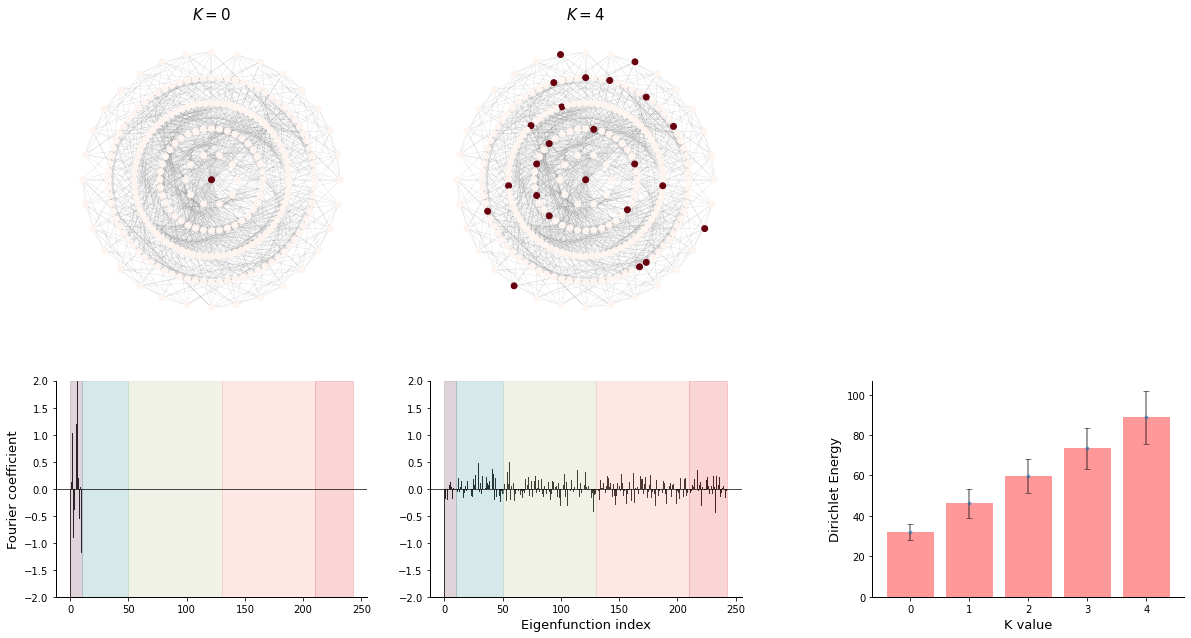

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(19,12.5))


ax_i = 0

for i in [0,4]:
    t = draw_radial_hierarchical(graph, 2, AMINOS, root=np.argmax(r1_NK_fitnesses[i].flatten()))
    nx.draw(t[0], t[1], node_size=35, edge_color='gray', width=0.1,cmap=plt.get_cmap('Reds'),
        node_color=np.array(list(landscapes_nmax[0][i].values())), ax=ax[0,ax_i],)
    ax[0,ax_i].set_title('$K = {}$'.format(i), fontsize=15)
    ax_i = ax_i+1
    
ax1_i=0
for i in [0,4]: 
    ax[1,ax1_i].bar(range(len(r1_landscapes_FT[i].flatten())), np.flip(r1_landscapes_FT[i]).flatten(),color='k')
    ax1_i = ax1_i+1

ax[1,2].errorbar(range(len(dirichlet_means)), dirichlet_means, yerr=dirichlet_stds, capsize=3, ecolor = "black", fmt='.', alpha=0.5)

ax[1,2].bar(range(len(dirichlet_means)), dirichlet_means, color='red', alpha=0.4)
#ax[1,2].bar(range(len(dirichlets)), dirichlets, color='red', alpha=0.3)
#ax[1,2].set_xticks(ticks=range(len(dirichlets)),labels=range(len(dirichlets)), minor=False)
    
spec_axes     = [ax[1,i] for i in range(2)] 
dir_axes      = ax[1,2]
dir_exp       = ax[0,2]

p1 = [i.axvspan(0,   10, alpha=0.3, color='#987284')  for i in spec_axes]
p2 = [i.axvspan(10,  50, alpha=0.3, color='#75B9BE')  for i in spec_axes]
p3 = [i.axvspan(50, 130, alpha=0.3, color='#D0D6B5')  for i in spec_axes]
p4 = [i.axvspan(130,210, alpha=0.3, color='#F9B5AC')  for i in spec_axes]
p5 = [i.axvspan(210,243, alpha=0.3, color='#EE7674')  for i in spec_axes]


for line in ['right', 'top']: 
    for axis in spec_axes:
        axis.spines[line].set_visible(False)            
for line in ['right', 'top']: 
        dir_axes.spines[line].set_visible(False)

for line in ['top','bottom','left','right']:
    for axis in spec_axes: 
        axis.spines[line].set_linewidth(1)
for line in ['top','bottom','left','right']:
    dir_axes.spines[line].set_linewidth(1)

for line in ['top','bottom','left','right']:
    dir_exp.spines[line].set_visible(False)

    
dir_exp.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
for axis in spec_axes: 
    axis.set_ylim(-2,2)
    #axis.set_xlabel('Eigenfunction index')
    axis.axhline(y=0, color='k', linestyle='-', linewidth=0.7)
    
    
for i in spec_axes:
    poss   = i.get_position()
    pss_1  = [poss.x0, poss.y0+0.12, poss.width, poss.height*0.7]
    i.set_position(pos=pss_1)
spec_axes[0].set_ylabel('Fourier coefficient', fontsize=13)
spec_axes[1].set_xlabel('Eigenfunction index', fontsize=13)

dir_poss = dir_axes.get_position()
dir_pss1 = [dir_poss.x0 + 0.05, dir_poss.y0+0.12, dir_poss.width, dir_poss.height*0.7]
dir_axes.set_position(dir_pss1)
dir_axes.set_ylabel('Dirichlet Energy', fontsize=13)
dir_axes.set_xlabel('K value', fontsize=13)

dir_exp_poss = dir_exp.get_position()
dir_exp_pss1 = [dir_exp_poss.x0 + 0.05, dir_exp_poss.y0, dir_exp_poss.width, dir_exp_poss.height]
dir_exp.set_position(dir_exp_pss1)
#dir_exp.set_ylabel('Dirichlet Energy', fontsize=13)
#dir_exp.set_xlabel('K value', fontsize=13)


fig.savefig('ruggedness-perspective-figure4.svg')
